# Problem Statement

According to the Centers for Disease Control and Prevention, the West Nile Virus (WNV) is a viral infection transmitted across humans through the bite of an infected mosquito. Mosquitoes first become infected when they feed on birds. 1 in 5 people who become infected with the virus develop a fever along with other symptoms such as body aches, rashes and diarrhea. About 1 in 150 people develop a serious illness that affects the central nervous system.

Kaggle launched a competition with a $40,000 prize money back in 2015 to predict West Nile Virus in mosquitoes across the city of Chicago. Though the competition has already ended, we're working on our own version of model on the same problem set as part of our Machine Learning curriculum with General Assembly. 

Our project aims to answer below problem statements:

1. Predict the probability of presence of West Nile Virus given weather, location, testing and spray data
2. Analyze to see if there are main contributing reasons to the manifestation of West Nile Virus
3. Recommendations on best practices to how to combat the spread of West Nile Virus

# Executive Summary

Our codebook is split to 3 main notebooks

1. Data Cleaning (`01. Data Cleaning.ipynb`)
2. EDA and Pre-processing (`02. EDA and Pre-processing.ipynb`)
3. Modelling (`03. Modelling.ipynb`)

`01. Data Cleaning.ipynb`

Here we include the codes where we did some basic cleaning of datasets. This include patching up `weather.csv` file onto our `train.csv` data set in order for us to proceed with EDA. We also address some data related issues like converting to the right data types as well taking a deeper look into some of the weather features provided.

`02. EDA and Pre-processing.ipynb`

We conduct EDA on the data that we clean from earlier notebook. Here we look into relationships of several features like mosquito species, temperature and others against the occurrence of West Nile Virus in order to give us an indicator on which features are more important and where we should do feature engineering on. More importantly, we explored the various correlations as well as cross-correlations on lagged and rolled features on some weather features.

`03. Modelling.ipynb`

This notebook contains the codes for our models. We pass our datasets through various models through a GridSearch and analyze our results to obtain the best model. We also provide some analysis on the important features as well as the metrics derived from our model. We also include a section on conclusion and recommendations here. 

# Import libraries

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import matplotlib as mpl
import seaborn as sns
from scipy.stats import ttest_ind

%matplotlib inline

In [2]:
# some matplotlib params to make the defaults a bit more readable
mpl.rcParams['figure.figsize'] = [8.0, 6.0]
mpl.rcParams['font.size'] = 15
mpl.rcParams['axes.spines.right'] = False
mpl.rcParams['axes.spines.top'] = False

In [3]:
spray = pd.read_csv('../assets/spray.csv')
test = pd.read_csv('../assets/test.csv')
train = pd.read_csv('../assets/train.csv')
weather = pd.read_csv('../assets/weather.csv')

# Weather.csv

In [4]:
weather.head()

,Station,Date,Tmax,Tmin,Tavg,Depart,DewPoint,WetBulb,Heat,Cool,...,CodeSum,Depth,Water1,SnowFall,PrecipTotal,StnPressure,SeaLevel,ResultSpeed,ResultDir,AvgSpeed
0,1,2007-05-01,83,50,67,14,51,56,0,2,...,,0,M,0.0,0.00,29.10,29.82,1.7,27,9.2
1,2,2007-05-01,84,52,68,M,51,57,0,3,...,,M,M,M,0.00,29.18,29.82,2.7,25,9.6
2,1,2007-05-02,59,42,51,-3,42,47,14,0,...,BR,0,M,0.0,0.00,29.38,30.09,13.0,4,13.4
3,2,2007-05-02,60,43,52,M,42,47,13,0,...,BR HZ,M,M,M,0.00,29.44,30.08,13.3,2,13.4
4,1,2007-05-03,66,46,56,2,40,48,9,0,...,,0,M,0.0,0.00,29.39,30.12,11.7,7,11.9


In [5]:
weather.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2944 entries, 0 to 2943
Data columns (total 22 columns):
 #   Column       Non-Null Count  Dtype  
---  ------       --------------  -----  
 0   Station      2944 non-null   int64  
 1   Date         2944 non-null   object 
 2   Tmax         2944 non-null   int64  
 3   Tmin         2944 non-null   int64  
 4   Tavg         2944 non-null   object 
 5   Depart       2944 non-null   object 
 6   DewPoint     2944 non-null   int64  
 7   WetBulb      2944 non-null   object 
 8   Heat         2944 non-null   object 
 9   Cool         2944 non-null   object 
 10  Sunrise      2944 non-null   object 
 11  Sunset       2944 non-null   object 
 12  CodeSum      2944 non-null   object 
 13  Depth        2944 non-null   object 
 14  Water1       2944 non-null   object 
 15  SnowFall     2944 non-null   object 
 16  PrecipTotal  2944 non-null   object 
 17  StnPressure  2944 non-null   object 
 18  SeaLevel     2944 non-null   object 
 19  Result

In [6]:
weather.describe().T

,count,mean,std,min,25%,50%,75%,max
Station,2944.0,1.500000,0.500085,1.0,1.0,1.5,2.0,2.0
Tmax,2944.0,76.166101,11.461970,41.0,69.0,78.0,85.0,104.0
Tmin,2944.0,57.810462,10.381939,29.0,50.0,59.0,66.0,83.0
DewPoint,2944.0,53.457880,10.675181,22.0,46.0,54.0,62.0,75.0
ResultSpeed,2944.0,6.960666,3.587527,0.1,4.3,6.4,9.2,24.1
ResultDir,2944.0,17.494905,10.063609,1.0,7.0,19.0,25.0,36.0


## Station

Check null values in each station. Null values are either represented by 'M' or '-'.

In [7]:
obj_cols = weather.select_dtypes(include=['object']).columns

In [8]:
for col in weather[obj_cols]:
    station_1 = len(weather[(weather[col].isin(['M','-'])) & (weather.Station==1)])
    print(col + ' has ' + str(station_1) + ' missing values at station 1')
    station_2 = len(weather[(weather[col].isin(['M','-'])) & (weather.Station==2)])
    print(col + ' has ' + str(station_2) + ' missing values at station 2')
    print()

Date has 0 missing values at station 1
Date has 0 missing values at station 2

Tavg has 0 missing values at station 1
Tavg has 11 missing values at station 2

Depart has 0 missing values at station 1
Depart has 1472 missing values at station 2

WetBulb has 3 missing values at station 1
WetBulb has 1 missing values at station 2

Heat has 0 missing values at station 1
Heat has 11 missing values at station 2

Cool has 0 missing values at station 1
Cool has 11 missing values at station 2

Sunrise has 0 missing values at station 1
Sunrise has 1472 missing values at station 2

Sunset has 0 missing values at station 1
Sunset has 1472 missing values at station 2

CodeSum has 0 missing values at station 1
CodeSum has 0 missing values at station 2

Depth has 0 missing values at station 1
Depth has 1472 missing values at station 2

Water1 has 1472 missing values at station 1
Water1 has 1472 missing values at station 2

SnowFall has 0 missing values at station 1
SnowFall has 1472 missing values at

There are many features which Station 2 does not collect. For example, Station 2 does not have records for Depth, Water1, Sunrise/Sunset etc. From the data dictionary we know that these are the AWOS stations that collect less data than the ASOS stations, which is Station 1. As such, we may elect to simply use data only from station 1. But first we must ensure that data collected from Station 2 is not so different from Station 1 so as to introduce meaningful information about weather.

Before that, we will try to impute as much data as we can.

In [9]:
# first, fix all our 'object' columns by imputing replacing our str values.
# these values are either 'M' or '-' for missing, or 'T' for Trace.
# Trace values refer to values measured by the sensor that are so small that they cannot show them with sufficient precision
# Hence we make the executive decision to set these to 0 instead.

weather.replace(['M','-'], np.nan, inplace=True)
weather.replace('  T', 0, inplace=True)

In [10]:
# Then we cast these columns to float now that they don't contain str values anymore
# Leave out Date, Codesum, Sunset and Sunrise for later

cols_to_change = weather.select_dtypes('object').drop(columns=['Date','CodeSum','Sunrise','Sunset']).columns
for col in cols_to_change:
    weather[col] = weather[col].astype(float)

In [11]:
# check dtypes
weather.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2944 entries, 0 to 2943
Data columns (total 22 columns):
 #   Column       Non-Null Count  Dtype  
---  ------       --------------  -----  
 0   Station      2944 non-null   int64  
 1   Date         2944 non-null   object 
 2   Tmax         2944 non-null   int64  
 3   Tmin         2944 non-null   int64  
 4   Tavg         2933 non-null   float64
 5   Depart       1472 non-null   float64
 6   DewPoint     2944 non-null   int64  
 7   WetBulb      2940 non-null   float64
 8   Heat         2933 non-null   float64
 9   Cool         2933 non-null   float64
 10  Sunrise      1472 non-null   object 
 11  Sunset       1472 non-null   object 
 12  CodeSum      2944 non-null   object 
 13  Depth        1472 non-null   float64
 14  Water1       0 non-null      float64
 15  SnowFall     1472 non-null   float64
 16  PrecipTotal  2942 non-null   float64
 17  StnPressure  2940 non-null   float64
 18  SeaLevel     2935 non-null   float64
 19  Result

## `Tavg`
We have 11 mising Tavg values. We can easily impute this using Tmax - Tmin. Doing also gives us slightly more precision than the initial interger values of Tavg.

In [12]:
(weather['Tmax'] + weather['Tmin']) /2

0       66.5
1       68.0
2       50.5
3       51.5
4       56.0
        ... 
2939    44.5
2940    41.5
2941    45.0
2942    40.0
2943    41.5
Length: 2944, dtype: float64

In [13]:
weather['Tavg'] = (weather['Tmax'] + weather['Tmin']) /2

## `Heat` and `Cool`
Heat measures the difference between `Tavg` and 65 deg F when `Tavg` is below 65, and Cool measures the opposite. Apart from not making sense, we can easily combine these features into 1 heat/cool column that simply measures the signed difference between `Tavg` and 65 deg F.

In [14]:
weather['Heat/Cool'] = weather['Tavg'] - 65
weather['Heat/Cool']

0        1.5
1        3.0
2      -14.5
3      -13.5
4       -9.0
        ... 
2939   -20.5
2940   -23.5
2941   -20.0
2942   -25.0
2943   -23.5
Name: Heat/Cool, Length: 2944, dtype: float64

In [15]:
# drop Heat and Cool
weather.drop(columns=['Heat','Cool'], inplace=True)

## `DewPoint` and `WetBulb`
**Wet bulb** temperature essentially measures how much water vapor the atmosphere can hold at current weather conditions. A lower wet bulb temperature means the air is drier and can hold more water vapor than it can at a higher wet bulb temperature.

**Dew points** indicate the amount moisture in the air. The higher the dew points, the higher the moisture content of the air at a given temperature.

To derive `DewPoint`, first find the dewpoint depression (temperature minus dewpoint). Then take this number and divide by 3. Subtract this number from the temperature.

In [16]:
weather.loc[weather['WetBulb'].isna(), 'WetBulb']

848    NaN
2410   NaN
2412   NaN
2415   NaN
Name: WetBulb, dtype: float64

In [17]:
mask = weather['WetBulb'].isna()
weather.loc[weather['WetBulb'].isna(), 'WetBulb'] = weather[mask]['Tavg'] - (weather[mask]['Tavg']-weather[mask]['DewPoint'])/3

## `SeaLevel` , `StnPressure` and `AvgSpeed` 
There's no logical imputation to be done for these, so we leave them as np.nan first. We can use SimpleImputer later on after we train test split.

In [18]:
# check df
weather.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2944 entries, 0 to 2943
Data columns (total 21 columns):
 #   Column       Non-Null Count  Dtype  
---  ------       --------------  -----  
 0   Station      2944 non-null   int64  
 1   Date         2944 non-null   object 
 2   Tmax         2944 non-null   int64  
 3   Tmin         2944 non-null   int64  
 4   Tavg         2944 non-null   float64
 5   Depart       1472 non-null   float64
 6   DewPoint     2944 non-null   int64  
 7   WetBulb      2944 non-null   float64
 8   Sunrise      1472 non-null   object 
 9   Sunset       1472 non-null   object 
 10  CodeSum      2944 non-null   object 
 11  Depth        1472 non-null   float64
 12  Water1       0 non-null      float64
 13  SnowFall     1472 non-null   float64
 14  PrecipTotal  2942 non-null   float64
 15  StnPressure  2940 non-null   float64
 16  SeaLevel     2935 non-null   float64
 17  ResultSpeed  2944 non-null   float64
 18  ResultDir    2944 non-null   int64  
 19  AvgSpe

## Hypothesis Testing
Since we have quite a few features missing from Station 2, it might be simpler to use Station 1's data only. However, we need to ensure that the data for each feature is not significantly different between stations.

TO do this, we'll split our data into Station 1 and Station 2, and perform a T-test on each feature to see if Station 1's data is different from Station 2's data. We'll use an alpha level of 0.01 to reject our null hypothesis that data from Station 1 is not different than data from Station 2.

In [19]:
stn1 = weather[weather['Station']==1]
stn2 = weather[weather['Station']==2]

for col in stn1.columns:
    try:
        print('T-test p value for {} is {}'.format(col, ttest_ind(stn1[col],stn2[col], nan_policy='omit')[1]))
    except:
        print('Could not do T-test for {}'.format(col))

T-test p value for Station is 0.0
Could not do T-test for Date
T-test p value for Tmax is 0.3757186883686098
T-test p value for Tmin is 1.5534153620432908e-08
T-test p value for Tavg is 0.0010971650075739226
T-test p value for Depart is 0.0
T-test p value for DewPoint is 0.6837540058676679
T-test p value for WetBulb is 0.1160927558963912
Could not do T-test for Sunrise
Could not do T-test for Sunset
Could not do T-test for CodeSum
T-test p value for Depth is 0.0
T-test p value for Water1 is 0.0
T-test p value for SnowFall is 0.0
T-test p value for PrecipTotal is 0.6579669603657681
T-test p value for StnPressure is 1.80989826166576e-25
T-test p value for SeaLevel is 0.11062800887582602
T-test p value for ResultSpeed is 0.6894611884754007
T-test p value for ResultDir is 0.3844438924103951
T-test p value for AvgSpeed is 0.8676908576839891
T-test p value for Heat/Cool is 0.0010971650075738688


C:\ProgramData\Anaconda3\lib\site-packages\scipy\stats\mstats_basic.py:1070: RuntimeWarning: divide by zero encountered in true_divide
  denom = ma.sqrt(svar*(1.0/n1 + 1.0/n2))  # n-D computation here!


From this, we see that we reject the null hypothesis for Tmin, Tavg, Cool, and StnPressure. Let's make some boxplots to visually inspect their differences.

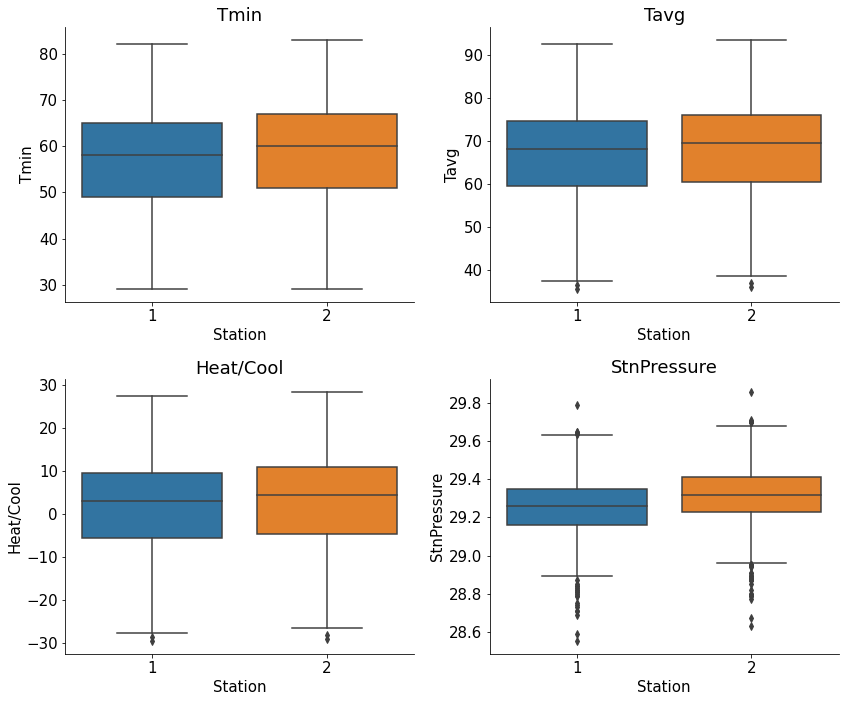

In [20]:
fig, ax = plt.subplots(2,2,figsize=(12,10))
ax = ax.ravel()
for n, col in enumerate(['Tmin','Tavg','Heat/Cool','StnPressure']):
    g = sns.boxplot(data=weather, x='Station', y=col, ax=ax[n])
    g.set_title(col)
plt.tight_layout();

Visually, these variables actually don't look that far off from each other. Perhaps StnPressure is the most significantly different, but the scale of the difference itself is very small. 

For the rest of our data, we will stick to using the data from Station 1 only. For these 4 features, we will use the mean of Station 1 and 2's data as our new aggregate features. However, since Tavg is a derived from Tmax and Tmin, and subsequently Heat/Cool from Tavg, we will take the mean of Tmin between Stations, and calculate Tavg and Heat/Cool from there again.

In [21]:
stn1 = weather[weather['Station']==1].copy().reset_index(drop=True)
stn2 = weather[weather['Station']==2].copy().reset_index(drop=True)


In [22]:
new_wx = weather[weather['Station']==1].copy().reset_index(drop=True)
new_wx['StnPressure'] = (stn1['StnPressure'] + stn2['StnPressure'])/2
new_wx['Tmin'] = (stn1['Tmin'] + stn2['Tmin']) / 2
new_wx['Tavg'] = (new_wx['Tmax'] + new_wx['Tmin']) / 2
new_wx['Heat/Cool'] = new_wx['Tavg'] - 65
new_wx.info()


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1472 entries, 0 to 1471
Data columns (total 21 columns):
 #   Column       Non-Null Count  Dtype  
---  ------       --------------  -----  
 0   Station      1472 non-null   int64  
 1   Date         1472 non-null   object 
 2   Tmax         1472 non-null   int64  
 3   Tmin         1472 non-null   float64
 4   Tavg         1472 non-null   float64
 5   Depart       1472 non-null   float64
 6   DewPoint     1472 non-null   int64  
 7   WetBulb      1472 non-null   float64
 8   Sunrise      1472 non-null   object 
 9   Sunset       1472 non-null   object 
 10  CodeSum      1472 non-null   object 
 11  Depth        1472 non-null   float64
 12  Water1       0 non-null      float64
 13  SnowFall     1472 non-null   float64
 14  PrecipTotal  1472 non-null   float64
 15  StnPressure  1469 non-null   float64
 16  SeaLevel     1467 non-null   float64
 17  ResultSpeed  1472 non-null   float64
 18  ResultDir    1472 non-null   int64  
 19  AvgSpe

Change our Date to datetime format, then set as index.

In [23]:
new_wx['Date'] = pd.to_datetime(new_wx['Date'])
new_wx.set_index('Date', inplace=True)

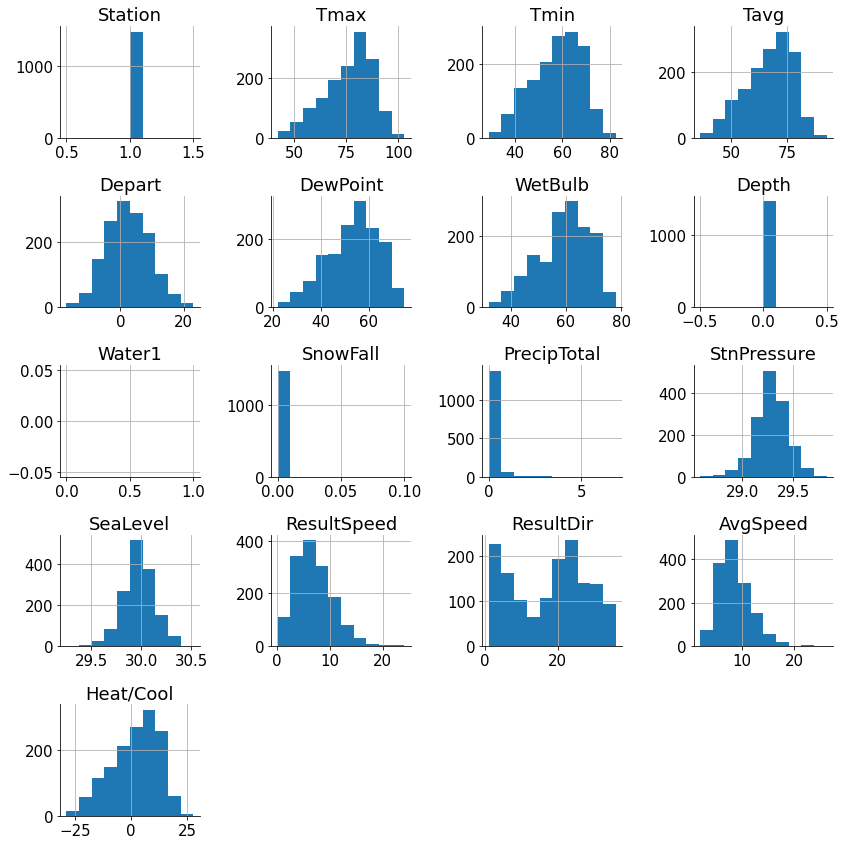

In [24]:
new_wx.hist(figsize=(12,12))
plt.tight_layout();

Drop Station, Depth, Water1, and SnowFall as they have no values or are almost all 0.

In [25]:
new_wx.drop(columns=['Station','Depth','Water1','SnowFall'], inplace=True)

## `Sunrise` and `Sunset`
These features currently list sunrise/set timings as 'hhmm' formatted string. Let's convert this to an actual datetime object, then use them to calculate the total hours of sunlight in a day as a timedelta.

There are some erroneous values in Sunset like 1760 and 1860, which obviously should be 1800 and 1900 respectively. pd.to_datetime is unable to deal with this so we fix these values first before proceeding.

In [26]:
def timefix(x):
    hh = x[:2]
    mm = x[2:]
    if mm == '60':
        hh = str(int(hh) + 1)
        return hh+'00'
    else:
        return x


In [27]:
new_wx['Sunset'] = new_wx['Sunset'].map(timefix)
# new_wx['Sunset'].astype(int).astype(str).value_counts()

In [28]:
# convert Sunrise and Sunset into datetime using the dataframe index as well.
new_wx['sunset'] = pd.to_datetime(new_wx.index.astype(str) + ' ' + new_wx['Sunset'], format='%Y-%m-%d %H%M')
new_wx['sunrise'] = pd.to_datetime(new_wx.index.astype(str) + ' ' + new_wx['Sunrise'], format='%Y-%m-%d %H%M')

In [29]:
# create timedeltas from sunset and sunrise to serve as total sunlight hours per day
new_wx['SunHours'] = new_wx['sunset'] - new_wx['sunrise']

In [30]:
new_wx['SunHours'].map(lambda x: x.total_seconds()/60)
new_wx['SunHours'] = new_wx['SunHours'].map(lambda x: x.total_seconds()/60)

## `CodeSum`

Meteorological codes tell us what kind of weather there is. We know that mosquitoes breed in water, so we're looking out for days with any kind of rain, as rainy days create ideal breeding conditions.

In [31]:
# these codes are all related to rain.
new_wx['isRainy'] = new_wx['CodeSum'].str.contains(r'TS|RA|DZ|SH').astype(int)

## `Humidity`

In [32]:
def convert_to_celcius(fahrenheit):
    return round((fahrenheit-32) / 1.8, 3)

In [33]:
def rel_humidity_calc(dewpoint, temperature):
#     saturation_vapor_pressure = (6.11 * 10) ** (7.5 * temperature / (237.7 + temperature))
#     actual_vapor_pressure = (6.11 * 10) ** (7.5 * dewpoint / (237.7 + dewpoint))
#     rel_humidity = (actual_vapor_pressure / saturation_vapor_pressure)*100

    rel_humidity = 100*(np.exp((17.625*dewpoint)/(243.04+dewpoint))/np.exp((17.625*temperature)/(243.04+temperature)))
    return round(rel_humidity,2)

In [34]:
new_wx['Humidity'] = rel_humidity_calc(new_wx['DewPoint'].map(convert_to_celcius), new_wx['Tavg'].map(convert_to_celcius))

# Train.csv

In [35]:
train['Date'] = pd.to_datetime(train['Date'])

In [37]:
train_new = train.groupby(['Date','Trap', 'Latitude', 'Longitude', 'Species']).sum()
train_new = train_new.reset_index()

In [38]:
train_new['WnvPresent'] = train_new['WnvPresent'].map(lambda x : 1 if x > 0 else x)

In [39]:
train_merged = train_new.merge(new_wx.reset_index(), on='Date', how='left')

In [40]:
train_new.shape

(8475, 9)

In [41]:
train_merged.shape


(8475, 30)

# Test.csv

In [43]:
test['Date'] = pd.to_datetime(test['Date'])

In [46]:
test_merged = test.merge(new_wx.reset_index(), on='Date', how='left')

In [47]:
test_merged.columns

Index(['Id', 'Date', 'Address', 'Species', 'Block', 'Street', 'Trap',
       'AddressNumberAndStreet', 'Latitude', 'Longitude', 'AddressAccuracy',
       'Tmax', 'Tmin', 'Tavg', 'Depart', 'DewPoint', 'WetBulb', 'Sunrise',
       'Sunset', 'CodeSum', 'PrecipTotal', 'StnPressure', 'SeaLevel',
       'ResultSpeed', 'ResultDir', 'AvgSpeed', 'Heat/Cool', 'sunset',
       'sunrise', 'SunHours', 'isRainy', 'Humidity'],
      dtype='object')

In [48]:
train_merged.columns

Index(['Date', 'Trap', 'Latitude', 'Longitude', 'Species', 'Block',
       'AddressAccuracy', 'NumMosquitos', 'WnvPresent', 'Tmax', 'Tmin', 'Tavg',
       'Depart', 'DewPoint', 'WetBulb', 'Sunrise', 'Sunset', 'CodeSum',
       'PrecipTotal', 'StnPressure', 'SeaLevel', 'ResultSpeed', 'ResultDir',
       'AvgSpeed', 'Heat/Cool', 'sunset', 'sunrise', 'SunHours', 'isRainy',
       'Humidity'],
      dtype='object')

In [49]:
test_merged = test_merged.drop(columns=['Address', 'Street', 'AddressNumberAndStreet'])

# Spray.csv

In [50]:
spray.head()

,Date,Time,Latitude,Longitude
0,2011-08-29,6:56:58 PM,42.391623,-88.089163
1,2011-08-29,6:57:08 PM,42.391348,-88.089163
2,2011-08-29,6:57:18 PM,42.391022,-88.089157
3,2011-08-29,6:57:28 PM,42.390637,-88.089158
4,2011-08-29,6:57:38 PM,42.390410,-88.088858


We observed number of observations without time

In [51]:
spray.isnull().sum()

Date           0
Time         584
Latitude       0
Longitude      0
dtype: int64

All the nulls look to be coming from '2011-09-07'

In [52]:
spray[spray['Time'].isnull()].groupby('Date').count()

,Time,Latitude,Longitude
Date,,,
2011-09-07,0,584,584


In [53]:
spray[spray.duplicated(keep=False)]

,Date,Time,Latitude,Longitude
484,2011-09-07,7:43:40 PM,41.983917,-87.793088
485,2011-09-07,7:43:40 PM,41.983917,-87.793088
489,2011-09-07,7:44:32 PM,41.986460,-87.794225
490,2011-09-07,7:44:32 PM,41.986460,-87.794225
491,2011-09-07,7:44:32 PM,41.986460,-87.794225
...,...,...,...,...
1025,2011-09-07,7:44:32 PM,41.986460,-87.794225
1026,2011-09-07,7:44:32 PM,41.986460,-87.794225
1027,2011-09-07,7:44:32 PM,41.986460,-87.794225
1028,2011-09-07,7:44:32 PM,41.986460,-87.794225


In [54]:
spray[(spray['Date'] == '2011-09-07') & (spray['Time'] == '7:44:32 PM')]

,Date,Time,Latitude,Longitude
489,2011-09-07,7:44:32 PM,41.98646,-87.794225
490,2011-09-07,7:44:32 PM,41.98646,-87.794225
491,2011-09-07,7:44:32 PM,41.98646,-87.794225
492,2011-09-07,7:44:32 PM,41.98646,-87.794225
493,2011-09-07,7:44:32 PM,41.98646,-87.794225
...,...,...,...,...
1025,2011-09-07,7:44:32 PM,41.98646,-87.794225
1026,2011-09-07,7:44:32 PM,41.98646,-87.794225
1027,2011-09-07,7:44:32 PM,41.98646,-87.794225
1028,2011-09-07,7:44:32 PM,41.98646,-87.794225


Looks like these are errorneous, we'll go ahead and drop duplicates

In [55]:
spray.shape

(14835, 4)

In [56]:
spray = spray.drop_duplicates()

In [57]:
spray.shape

(14294, 4)

# Export

Remaining null values are to be imputed after train test split by fitting SimpleImputer on the train set, then transforming both the train and test sets.

In [58]:
new_wx.to_csv('../data_clean/weather.csv')
train_merged.to_csv('../data_clean/train.csv', index=False)
test_merged.to_csv('../data_clean/test.csv', index=False)
spray.to_csv('../data_clean/spray.csv', index=False)